In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime
import tqdm
import re
import time
from string import punctuation
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb
from sklearn.model_selection import train_test_split

import torch, torch.nn as nn
import torch.nn.functional as F

sns.set_style('darkgrid')
mpl.rcParams['figure.figsize'] = [15,10]

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from kaggle.competitions import nflrush

# Utils

In [36]:
import pandas as pd
import numpy as np
from string import punctuation
import datetime
import re
import torch
import math

def crps(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred), axis=1)

def yard_to_cdf(yard):
    yard = np.round(yard).astype(int)
    indices = yard+99
    cdfs = np.zeros((yard.shape[0], 199))
    for i in range(len(cdfs)):
        cdfs[i, indices[i]:] = 1
    return cdfs

def cdf_to_yard(cdf):
    yard_index = (cdf==1).argmax(axis=1)
    yard = yard_index-99
    return yard


def cdf_to_yard_torch(cdf):
    yard_index = torch.sum((torch.as_tensor(cdf) <= 0),dim=1)
    yard = yard_index-99
    return yard

def crps_torch(y_true, y_pred):
    y_true = torch.as_tensor(y_true)
    y_pred = torch.as_tensor(y_pred)
    return torch.mean((y_true - y_pred).pow(2), dim=1)

def crps_loss(y_true, y_pred_pdf):
    y_pred_cdf = torch.cumsum(torch.as_tensor(y_pred_pdf), dim=1)
    return crps_torch(y_true, y_pred_cdf).mean()

def crps_loss_cdf(y_true, y_pred_cdf):
    return crps_torch(y_true, y_pred_cdf).mean()
    
def clean_StadiumType(txt):
    if pd.isna(txt):
        return np.nan
    txt = txt.lower()
    txt = ''.join([c for c in txt if c not in punctuation])
    txt = re.sub(' +', ' ', txt)
    txt = txt.strip()
    txt = txt.replace('outside', 'outdoor')
    txt = txt.replace('outdor', 'outdoor')
    txt = txt.replace('outddors', 'outdoor')
    txt = txt.replace('outdoors', 'outdoor')
    txt = txt.replace('oudoor', 'outdoor')
    txt = txt.replace('indoors', 'indoor')
    txt = txt.replace('ourdoor', 'outdoor')
    txt = txt.replace('retractable', 'rtr.')
    return txt

def transform_StadiumType(txt):
    if pd.isna(txt):
        return np.nan
    if 'outdoor' in txt or 'open' in txt:
        return 1
    if 'indoor' in txt or 'closed' in txt:
        return 0
    return np.nan

def str_to_seconds(txt):
    txt = txt.split(':')
    ans = int(txt[0])*60 + int(txt[1]) + int(txt[2])/60
    return ans

def str_to_float(txt):
    try:
        return float(txt)
    except Exception as e:
        return np.NaN

def map_weather(txt):
    ans = 1
    if pd.isna(txt):
        return 0
    if 'partly' in txt:
        ans*=0.5
    if 'climate controlled' in txt or 'indoor' in txt:
        return ans*3
    if 'sunny' in txt or 'sun' in txt:
        return ans*2
    if 'clear' in txt:
        return ans
    if 'cloudy' in txt:
        return -ans
    if 'rain' in txt or 'rainy' in txt:
        return -2*ans
    if 'snow' in txt:
        return -3*ans
    return 0

def final_drop_cols(df):
    """
        Drop columns not used in X
    """
    cols_to_drop = [
        'Yards',
        'PlayDirection', 
        'TeamOnOffense', 'NflId', 'NflIdRusher',
        'TimeHandoff', 'TimeSnap', 'PlayerBirthDate',
        'FieldPosition',
         'DisplayName',
         'PossessionTeam',
         'PlayerCollegeName',
         'Position',
         'HomeTeamAbbr',
         'VisitorTeamAbbr',
         'Stadium',
         'Location',
         'GameId', 'PlayId', 'IsRusher', 'Team',
         'IsRusher']
    cols_to_drop = list(set(cols_to_drop).intersection(set(list(df.columns))))
    df = df.drop(cols_to_drop, axis=1)
    return df

def standartize_orientations(df):
    """
        https://www.kaggle.com/cpmpml/initial-wrangling-voronoi-areas-in-python
    
        Make sure the offensive team is always moving left to right.
    """
    df['ToLeft'] = df.PlayDirection == "left"
    df['TeamOnOffense'] = "home"
    df.loc[df.PossessionTeam != df.HomeTeamAbbr, 'TeamOnOffense'] = "away"
    df['IsOnOffense'] = df.Team == df.TeamOnOffense # Is player on offense?
    df['HomeOnOffense'] = (df['TeamOnOffense'] == 'home').astype(int)

    df['YardLine_std'] = 100 - df.YardLine
    df.loc[df.FieldPosition.fillna('') == df.PossessionTeam,  
              'YardLine_std'
             ] = df.loc[df.FieldPosition.fillna('') == df.PossessionTeam,  
              'YardLine']
    df['X_std'] = df.X
    df.loc[df.ToLeft, 'X_std'] = 120 - df.loc[df.ToLeft, 'X'] 
    df['Y_std'] = df.Y
    df.loc[df.ToLeft, 'Y_std'] = 160/3 - df.loc[df.ToLeft, 'Y'] 
    
    df['Dir_rad'] = np.mod(90 - df.Dir, 360) * math.pi/180.0
    df['Dir_std'] = df.Dir_rad
    df.loc[df.ToLeft, 'Dir_std'] = np.mod(np.pi + df.loc[df.ToLeft, 'Dir_rad'], 2*np.pi)

    df['Orientation_rad'] = np.mod(df.Orientation, 360) * math.pi/180.0

    df.loc[df.Season >= 2018, 'Orientation_rad'
         ] = np.mod(df.loc[df.Season >= 2018, 'Orientation'] - 90, 360) * math.pi/180.0

    df['Orientation_rad'] = np.mod(df.Orientation, 360) * math.pi/180.0
    df.loc[df.Season >= 2018, 'Orientation_rad'
             ] = np.mod(df.loc[df.Season >= 2018, 'Orientation'] - 90, 360) * math.pi/180.0
    df['Orientation_std'] = df.Orientation_rad
    df.loc[df.ToLeft, 'Orientation_std'] = np.mod(math.pi + df.loc[df.ToLeft, 'Orientation_rad'], 2*math.pi)
    
    replace_cols = ['YardLine', 'X', 'Y', 'Dir', 'Orientation']
    for col in replace_cols:
        df[col] = df[col+'_std']
        df.drop([col+'_std'], axis=1, inplace=True)

    drop_cols = ['Dir_rad', 'Orientation_rad']
    for col in drop_cols:
        df.drop([col], axis=1, inplace=True)

    return df

def clean_turf(df):
    Turf = {'Field Turf':'Artificial', 'A-Turf Titan':'Artificial', 'Grass':'Natural', 'UBU Sports Speed S5-M':'Artificial', 
        'Artificial':'Artificial', 'DD GrassMaster':'Artificial', 'Natural Grass':'Natural', 
        'UBU Speed Series-S5-M':'Artificial', 'FieldTurf':'Artificial', 'FieldTurf 360':'Artificial', 'Natural grass':'Natural', 'grass':'Natural', 
        'Natural':'Natural', 'Artifical':'Artificial', 'FieldTurf360':'Artificial', 'Naturall Grass':'Natural', 'Field turf':'Artificial', 
        'SISGrass':'Artificial', 'Twenty-Four/Seven Turf':'Artificial', 'natural grass':'Natural'} 

    turf_type = df['Turf'].map(Turf)
    df['TurfIsNatural'] = (turf_type == 'Natural')
    df = df.drop(['Turf'], axis=1)
    return df

def clean_abbrs(df):
    # CAREFUL. What if a new team appears?
    map_abbr = {'ARI': 'ARZ', 'BAL': 'BLT', 'CLE': 'CLV', 'HOU': 'HST'}
    for abb in df['PossessionTeam'].unique():
        map_abbr[abb] = abb

    def safe_map(val):
        if map_abbr.get('val'):
            return map_abbr[val]
        else:
            return val

    df['PossessionTeam'] = df['PossessionTeam'].apply(safe_map)
    df['HomeTeamAbbr'] = df['HomeTeamAbbr'].apply(safe_map)
    df['VisitorTeamAbbr'] = df['VisitorTeamAbbr'].apply(safe_map)
    return df

def encode_formations(df):
    # Formation columns
    df = pd.concat([df.drop(['OffenseFormation'], axis=1), pd.get_dummies(df['OffenseFormation'], prefix='OffenseFormation')], axis=1)
    # Filling missing dummy columns at test stage
    expected_columns = ['OffenseFormation_ACE',
         'OffenseFormation_EMPTY',
         'OffenseFormation_JUMBO',
         'OffenseFormation_PISTOL',
         'OffenseFormation_SHOTGUN',
         'OffenseFormation_SINGLEBACK',
         'OffenseFormation_WILDCAT',
         'OffenseFormation_I_FORM']
    for col in expected_columns:
        if not col in df.columns:
            df[col] = 0
    return df 

def clean_weather(df):
    df['WindSpeed'] = df['WindSpeed'].apply(lambda x: x.lower().replace('mph', '').strip() if not pd.isna(x) else x)
    df['WindSpeed'] = df['WindSpeed'].apply(lambda x: (int(x.split('-')[0])+int(x.split('-')[1]))/2 if not pd.isna(x) and '-' in x else x)
    df['WindSpeed'] = df['WindSpeed'].apply(lambda x: (int(x.split()[0])+int(x.split()[-1]))/2 if not pd.isna(x) and type(x)!=float and 'gusts up to' in x else x)
    df['WindSpeed'] = df['WindSpeed'].apply(str_to_float)

    df = df.drop(['WindDirection'], axis=1)

    df['GameWeather'] = df['GameWeather'].str.lower()
    indoor = "indoor"
    df['GameWeather'] = df['GameWeather'].apply(lambda x: indoor if not pd.isna(x) and indoor in x else x)
    df['GameWeather'] = df['GameWeather'].apply(lambda x: x.replace('coudy', 'cloudy').replace('clouidy', 'cloudy').replace('party', 'partly') if not pd.isna(x) else x)
    df['GameWeather'] = df['GameWeather'].apply(lambda x: x.replace('clear and sunny', 'sunny and clear') if not pd.isna(x) else x)
    df['GameWeather'] = df['GameWeather'].apply(lambda x: x.replace('skies', '').replace("mostly", "").strip() if not pd.isna(x) else x)
    df['GameWeather'] = df['GameWeather'].apply(map_weather)
    return df

def encode_personell(df):
    # DefensePersonnel
    counts = []
    for i, val in df['DefensePersonnel'].str.split(',').iteritems():
        row = {'OL': 0, 'RB': 0, 'TE': 0, 'WR': 0, 'DL': 0, 'DB': 0, 'LB': 0, 'QB': 0}
        if val is np.NaN:
            counts.append({})
            continue
        for item in val:
            name, number = item.strip().split(' ')[::-1]
            row[name] = int(number)
        counts.append(row)
    defense_presonell_df = pd.DataFrame(counts)
    defense_presonell_df.columns = ['defense_'+x for x in defense_presonell_df.columns]
    defense_presonell_df = defense_presonell_df.fillna(0).astype(int)
    defense_presonell_df.index = df.index
    df = pd.concat([df.drop(['DefensePersonnel'], axis=1), defense_presonell_df], axis=1)


    # OffensePersonnel
    counts = []
    for i, val in df['OffensePersonnel'].str.split(',').iteritems():
        row = {'OL': 0, 'RB': 0, 'TE': 0, 'WR': 0, 'DL': 0, 'DB': 0, 'LB': 0, 'QB': 0}
        if val is np.NaN:
            counts.append({})
            continue
        for item in val:
            name, number = item.strip().split(' ')[::-1]
            row[name] = int(number)
        counts.append(row)
    offense_personnel_df = pd.DataFrame(counts)
    offense_personnel_df.columns = ['offense_'+x for x in offense_personnel_df.columns]
    offense_personnel_df = offense_personnel_df.fillna(0).astype(int)
    offense_personnel_df.index = df.index
    df = pd.concat([df.drop(['OffensePersonnel'], axis=1), offense_personnel_df], axis=1)
    return df

def engineer_features(df):
    df['DefendersInTheBox_vs_Distance'] = (df['DefendersInTheBox'] / df['Distance'])
    return df


def preprocess_features(df):
    """Accepts df like train data, returns cleaned, standartized and enriched df"""

    df = clean_abbrs(df)

    df = standartize_orientations(df)

    df = clean_turf(df)


    df['StadiumType'] = df['StadiumType'].apply(clean_StadiumType)
    df['StadiumTypeShort'] = df['StadiumType'].apply(transform_StadiumType)
    df = df.drop(['StadiumType'], axis=1)

    df['HomeField'] = df['FieldPosition'] == df['HomeTeamAbbr']
    df['Field_eq_Possession'] = df['FieldPosition'] == df['PossessionTeam']
    df['HomePossesion'] = (df['PossessionTeam'] == df['HomeTeamAbbr'])

    df = encode_formations(df)

    df['GameClock'] = df['GameClock'].apply(str_to_seconds)

    df['PlayerHeight'] = df['PlayerHeight'].apply(lambda x: 12*int(x.split('-')[0])+int(x.split('-')[1]))
    df['PlayerBMI'] = 703*(df['PlayerWeight']/(df['PlayerHeight'])**2)

    df['TimeHandoff'] = pd.to_datetime(df['TimeHandoff'], utc=True)
    df['TimeSnap'] = pd.to_datetime(df['TimeSnap'], utc=True)
    df['TimeDelta'] = (df['TimeHandoff']-df['TimeSnap']).apply(lambda x: x.total_seconds())
    df['PlayerBirthDate'] = df['PlayerBirthDate'].apply(lambda x: datetime.datetime.strptime(x, "%m/%d/%Y"))
    df['PlayerBirthDate'] = pd.to_datetime(df['PlayerBirthDate'], utc=True)

    seconds_in_year = 60*60*24*365.25
    df['PlayerAge'] = (df['TimeHandoff']-df['PlayerBirthDate']).apply(lambda x: x.total_seconds())/seconds_in_year
    # df = df.drop([], axis=1)

    df = clean_weather(df)

    df['IsRusher'] = df['NflId'] == df['NflIdRusher']
    

    df = encode_personell(df)

    # Feature engineering
    df = engineer_features(df)

    df = sort_df(df)
    
    return df

def sort_df(df):
    df.sort_values(by=['PlayId', 'IsOnOffense', 'IsRusher'], inplace=True)
    return df

def make_x(df, fillna=True):
    source_play_id = df['PlayId']

    df = final_drop_cols(df)

    if fillna:
        df.fillna(-999, inplace=True)

    # Player features
    cols_player = ['X',
         'Y',
         'S',
         'A',
         'Dis',
         'Orientation',
         'Dir',
         'JerseyNumber',
         'PlayerHeight',
         'PlayerWeight',
         'PlayerBMI',
         'PlayerAge']

    all_cols_player = np.array([[f'pl{num}_'+x for x in cols_player] for num in range(1, 23)]).flatten()
    # print('cols player', all_cols_player)

    X = np.array(df[cols_player]).reshape(-1, len(cols_player)*22)

    play_id_index = source_play_id[::22]
    X_df = pd.DataFrame(X, columns=all_cols_player, index=play_id_index)

    assert df[cols_player].shape[0] == X_df.shape[0] * 22
    assert df[cols_player].shape[1] == X_df.shape[1] / 22

    # Play features
    # print(list(df.drop(cols_player, axis=1).columns))
    cols_play = ['Season', 'YardLine', 'Quarter', 'GameClock', 'Down', 'Distance', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay', 'DefendersInTheBox', 'Week', 'GameWeather', 'Temperature', 'Humidity', 'WindSpeed', 'ToLeft', 'IsOnOffense', 'HomeOnOffense', 'TurfIsNatural', 'StadiumTypeShort', 'HomeField', 'Field_eq_Possession', 'HomePossesion', 'OffenseFormation_ACE', 'OffenseFormation_EMPTY', 'OffenseFormation_I_FORM', 'OffenseFormation_JUMBO', 'OffenseFormation_PISTOL', 'OffenseFormation_SHOTGUN', 'OffenseFormation_SINGLEBACK', 'OffenseFormation_WILDCAT', 'TimeDelta', 'defense_DB', 'defense_DL', 'defense_LB', 'defense_OL', 'defense_QB', 'defense_RB', 'defense_TE', 'defense_WR', 'offense_DB', 'offense_DL', 'offense_LB', 'offense_OL', 'offense_QB', 'offense_RB', 'offense_TE', 'offense_WR', 'DefendersInTheBox_vs_Distance']

    X_play_col = np.zeros(shape=(X.shape[0], len(cols_play)))
    for i, col in enumerate(cols_play):
        X_play_col[:, i] = df[col][::22]

    X_play_col_df = pd.DataFrame(X_play_col, columns=cols_play, index=play_id_index)
    assert X_df.shape[0] == X_play_col_df.shape[0]
    X_df = pd.concat([X_df, X_play_col_df], axis=1)

    assert X_df.shape[0] == source_play_id.drop_duplicates().count()
    return X_df

def make_y(X, df):
    y = np.zeros(shape=(X.shape[0], 199))
    for i, yard in enumerate(df['Yards'][::22]):
        y[i, yard+99:] = np.ones(shape=(1, 100-yard))
    return y



In [5]:
# df_train = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2020/train.csv', dtype={'WindSpeed': 'object'})
df_train = pd.read_csv('data/train.csv', dtype={'WindSpeed': 'object'})

In [8]:
df_train_preprocessed = preprocess_features(df_train)

In [37]:
X_train = make_x(df_train_preprocessed, fillna=True)
y_train = make_y(X_train, df_train_preprocessed)

In [38]:
X_train.shape, y_train.shape

((23171, 312), (23171, 199))

# NN

In [46]:
N_FEATURES = X_train.shape[1]

In [47]:
def iterate_minibatches(X, y, batchsize):
    X = torch.as_tensor(X)
    y = torch.as_tensor(y)
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

In [48]:
DEVICE = 'cpu'
BATCH_SIZE = 32
LEARNING_RATE = 0.002
NUM_EPOCHS = 100
EARLY_STOP_AFTER = 10
WEIGHT_DECAY = 0.0002
SCHEDULER_PATIENCE = 5
L1_LOSS_WEIGHT = 0.001

In [49]:
class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(N_FEATURES, N_FEATURES),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.BatchNorm1d(N_FEATURES),
            nn.Linear(N_FEATURES, N_FEATURES),
            nn.ReLU(),
            nn.BatchNorm1d(N_FEATURES),
            nn.Linear(N_FEATURES, N_FEATURES),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.BatchNorm1d(N_FEATURES),
        )
        self.head_classifier = nn.Sequential(
            nn.Linear(N_FEATURES, 199),
            nn.Softmax()
        )
        self.head_regressor = nn.Sequential(
            nn.Linear(N_FEATURES, 1),
        )

    def forward(self, x_batch):
        latent_out = self.seq.forward(x_batch)
        return self.head_classifier(latent_out), self.head_regressor(latent_out)

    def loss(self, x_batch, y_batch):
        y_batch = torch.as_tensor(y_batch).double().to(device=DEVICE)
        y_pdf, y_yard = self(x_batch)
        loss_crps = crps_loss(y_batch, y_pdf)
        
        y_yard = y_yard.flatten().double()
        y_batch_yard = cdf_to_yard_torch(y_batch).double()
        loss_mae = torch.mean(torch.abs(y_batch_yard-y_yard))
        return loss_crps + loss_mae*L1_LOSS_WEIGHT

    def predict_pdf(self, x_batch):
        y_pdf, y_yard = self(x_batch)
        return y_pdf
    
    def predict_cdf(self, x_batch):
        y_pred_pdf = self.predict_pdf(x_batch)
        y_pred_pdf = y_pred_pdf.cpu().data
        y_pred_cdf = torch.cumsum(y_pred_pdf, dim=1).data.numpy()
        y_pred_cdf = np.round(np.clip(y_pred_cdf, 0, 1), 10)
        return y_pred_cdf

model = NeuralNet()
model = model.double().to(device=DEVICE)

# Train utils

In [50]:
def train(model, opt, scheduler, X_train, y_train, X_val, y_val, early_stop_patience, batch_size, n_epochs):
    train_loss = []
    train_loss_stds = []
    val_accuracy = []
    val_accuracy_stds = []

    best_val_acc = None
    best_model = None
    patience = 0

    for epoch in range(n_epochs):
        try:
            opt.zero_grad()

            start_time = time.time()
            model.train(True)
            epoch_loss = []

            for X_batch, y_batch in iter(iterate_minibatches(X_train, y_train, batch_size)):
                loss = model.loss(X_batch, y_batch)
                epoch_loss.append(float(loss.item()))
                loss.backward()
                opt.step()
                opt.zero_grad()

            train_loss.append(np.mean(epoch_loss))
            train_loss_stds.append(np.std(epoch_loss))
            model.train(False)

            epoch_val_acc = []
            for X_batch, y_batch in iter(iterate_minibatches(X_val, y_val, batch_size)): 
                y_val_pred_cdf = model.predict_cdf(X_batch)
                val_loss = crps_loss_cdf(y_batch, y_val_pred_cdf)
                epoch_val_acc.append(val_loss.item())
            val_acc = np.mean(epoch_val_acc)
            val_accuracy.append(val_acc)
            val_accuracy_stds.append(np.std(epoch_val_acc))


            scheduler.step(val_acc)

            # Then we print the results for this epoch:
            print("Epoch {} of {} took {:.3f}s".format(
                epoch + 1, n_epochs, time.time() - start_time))
            print("  training loss: \t{:.6f}".format(train_loss[-1]))
            print("  validation score: \t\t\t{:.6f}".format(val_accuracy[-1]))

            if best_val_acc is None or val_acc < best_val_acc:
                best_val_acc = val_acc
                patience = 0
                torch.save(model.state_dict(), 'best_model')
            else:
                patience += 1
                print(f'Validation score has not improved for {patience} epochs.')
            if patience >= early_stop_patience:
                print('Early stopping.')
                break
        except KeyboardInterrupt:
            break
    model.load_state_dict(torch.load('best_model'))
    model.train(False)

    history = {
        'train_loss': train_loss,
        'train_loss_stds': train_loss_stds,
        'val_accuracy': val_accuracy,
        'val_accuracy_stds': val_accuracy_stds,
    }
    
    return model, history

def train_nn_pipeline(model, X, y, early_stop_after=EARLY_STOP_AFTER, batch_size=BATCH_SIZE, n_epochs=NUM_EPOCHS):
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)
    
    opt = torch.optim.Adamax(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', patience=SCHEDULER_PATIENCE, verbose=True, threshold=1e-6, eps=1e-9)

    model, train_history = train(model, opt, scheduler, X_train, y_train, X_val, y_val, early_stop_after, batch_size, n_epochs)
    
    return model, scaler, train_history

def nn_pipeline_predict(model, scaler, X):
    X = torch.as_tensor(scaler.transform(X)).to(device=DEVICE)
    y_pred = model.predict_cdf(X)
    return y_pred

# Training

In [51]:
model, scaler, history = train_nn_pipeline(model, X_train, y_train, n_epochs=NUM_EPOCHS)

Epoch 1 of 100 took 17.961s
  training loss: 	0.020740
  validation score: 			0.014938
Epoch 2 of 100 took 17.954s
  training loss: 	0.018619
  validation score: 			0.015204
Validation score has not improved for 1 epochs.


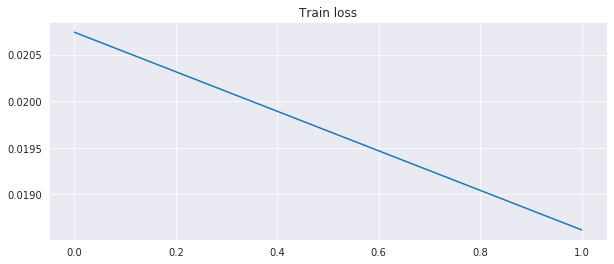

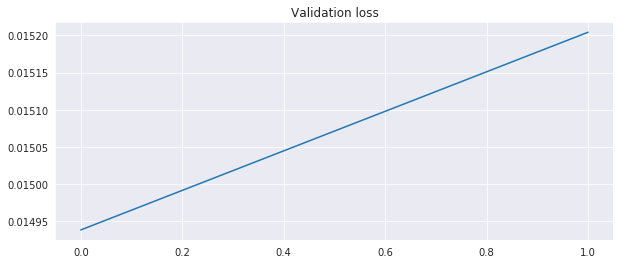

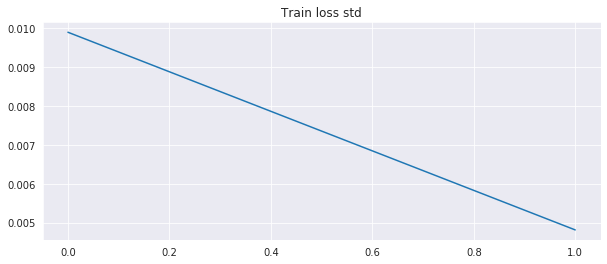

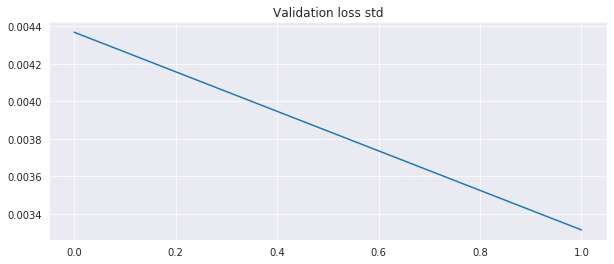

In [57]:
plt.figure(figsize=(10, 4))
sns.lineplot(range(len(history['train_loss'])), history['train_loss'])
plt.title('Train loss')
plt.show()

plt.figure(figsize=(10, 4))
sns.lineplot(range(len(history['val_accuracy'])), history['val_accuracy'])
plt.title('Validation loss')
plt.show()

plt.figure(figsize=(10, 4))
sns.lineplot(range(len(history['train_loss_stds'])), history['train_loss_stds'])
plt.title('Train loss std')
plt.show()

plt.figure(figsize=(10, 4))
sns.lineplot(range(len(history['val_accuracy_stds'])), history['val_accuracy_stds'])
plt.title('Validation loss std')
plt.show()

# SUBMIT

In [58]:
env = nflrush.make_env()

Exception: You can only call `make_env()` once.

In [59]:
def get_predictions(df_test, y_test, model):
    X = make_x(preprocess_features(df_test), fillna=True)
    y_pred = nn_pipeline_predict(model, scaler, X)
    return y_pred

In [60]:
# preprocess_features(df_test).columns

In [61]:
# set(make_x(df_train_preprocessed).columns).difference(set(make_x(preprocess_features(df_test), fillna=True)))

In [62]:
# set(make_x(preprocess_features(df_test), fillna=True).columns).difference(set(make_x(df_train_preprocessed).columns))

In [63]:
iter_test = env.iter_test()

In [68]:
y_pred = get_predictions(df_test, y_cdf_test, model)

In [69]:
for df_test, y_cdf_test in tqdm.tqdm(iter_test):
    y_pred = get_predictions(df_test, y_cdf_test, model)
    env.predict(pd.DataFrame(data=y_pred,columns=y_cdf_test.columns))


0it [00:00, ?it/s]

In [ ]:
env.write_submission_file()